In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

SyntaxError: invalid syntax (ngfunction.py, line 1)

In [151]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [152]:
pars.set_matter_power(redshifts=[1.2], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [153]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale


In [154]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [176]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

0.7299999999998781

In [156]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [157]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [158]:
#Dati per la funzione teorica
#om=(0.134)/(h**2)  #PRESO DA QUELLE INIZIALI MA NON TORNANO COI DATI, ho usato una h diversa
#omb= 0.31  # densità di materia per z=0, presa da libro
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.778512098536979

In [159]:
print(f)
print(omz**0.545)

[0.87580445]
0.8724481469391995


In [160]:
##Errori dei dati simulati
ng= 13.5e4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol*1/(2*np.pi)**2 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [161]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.020709468196232487

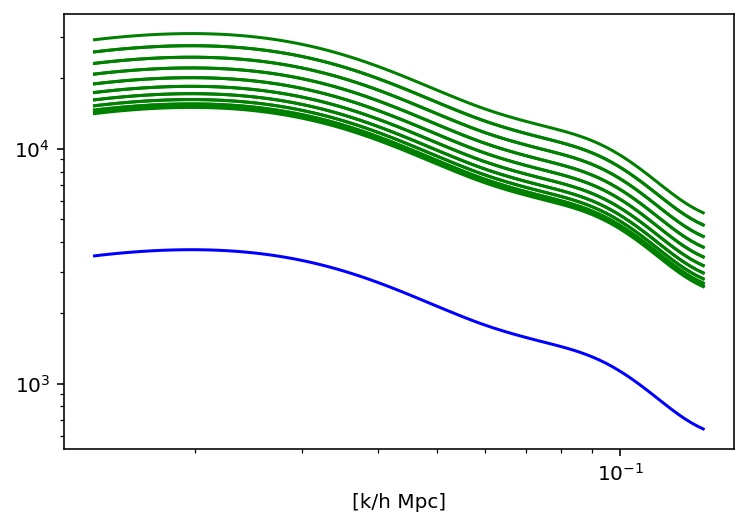

In [162]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[3035.17110083 2986.13370417 2936.7842744  2887.13735145 2837.20882101
 2787.0132288  2736.56427761 2685.87736671 2634.9696301  2583.85873856
 2532.56208644 2481.09871906 2429.48949255 2377.75632045 2325.92037363
 2274.00414665 2222.03198449 2170.02979114 2118.02354454 2066.04020517
 2014.1084458  1962.2585218  1910.52172345 1858.93032711 1807.51791505
 1756.31925985 1705.37071844 1654.71047592 1604.37737628 1554.41064532
 1504.8506436  1455.74118124 1407.12623204 1359.04883234 1311.55165859
 1264.68217712 1218.48859216 1173.01626135 1128.30791101 1084.41026264
 1041.37281197  999.2401099   958.05157013  917.84775056  878.67535455
  840.57469498  803.57844628  767.71516869  733.01877674  699.51734713
  667.23000086  636.16931987  606.35523635  577.8059623   550.5295893
  524.52499421  499.77781467  476.26229981  453.94871713  432.80444013
  412.80508083  393.94468405  376.21321502  359.59457121  344.04923795
  329.48542295  315.81107052  302.9433497   290.80705718  279.33360334
  268.4

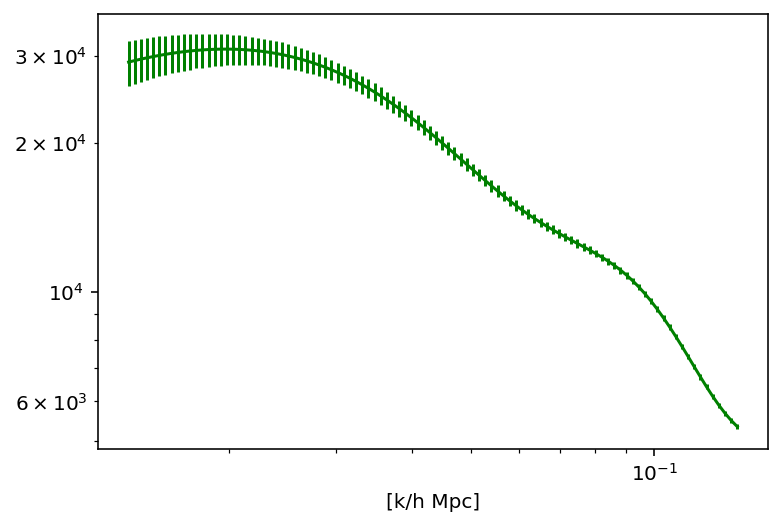

In [163]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [164]:
gammas= np.arange(0.52,0.56,0.001)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



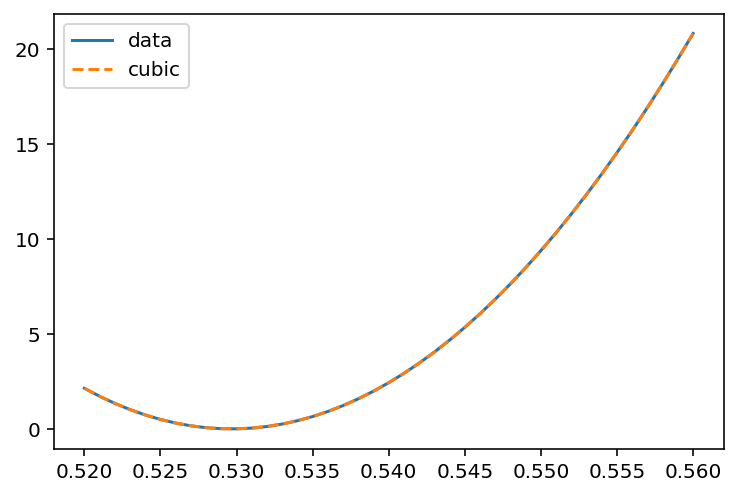

In [165]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [166]:
type(interpol)
y=lambda x: interpol(x)


In [167]:

minimo = optimize.least_squares(y,0.53)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 7.858575090225368e-16
         fun: array([3.96448612e-08])
        grad: array([2.39994905e-09])
         jac: array([[0.0605362]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 9
        njev: 9
  optimality: 2.3999490471956272e-09
      status: 1
     success: True
           x: array([0.5296656])

In [168]:
chi2min= y(min1)

In [169]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.53

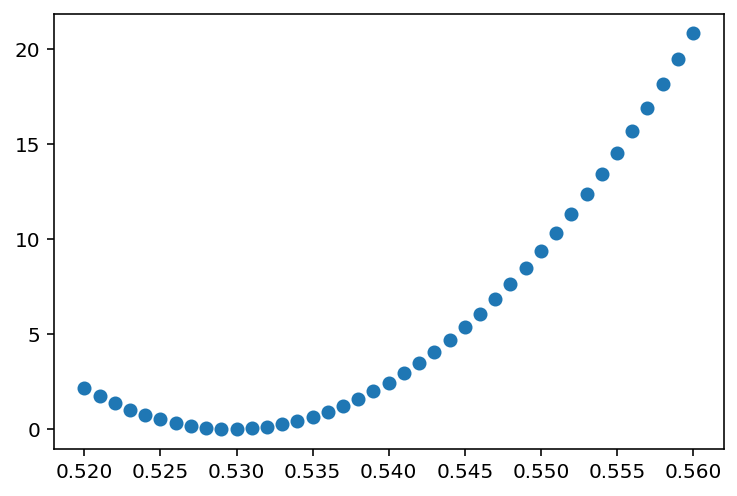

In [170]:
plt.scatter(gammas,chi2)

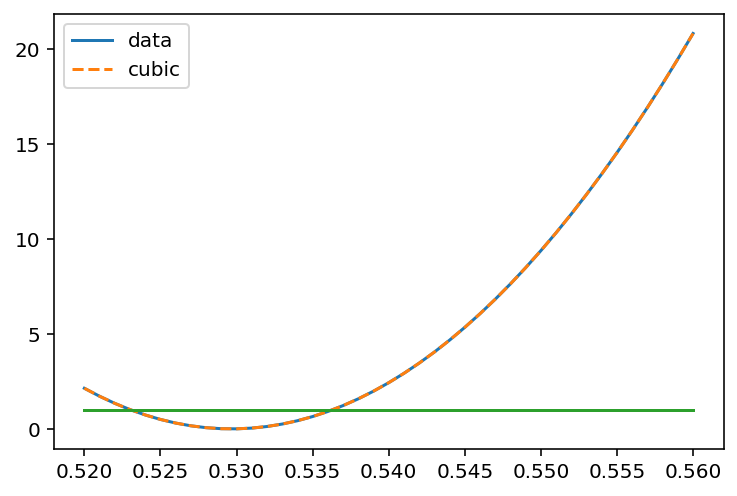

In [171]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.52,0.56,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [172]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.52,0.53)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,0.53,0.56)
print(error1,error2)

0.5230500842084337 0.5362919470668714


In [173]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.006615519525082769
0.006626343333354989


In [174]:
print("Il valore di gamma trovato è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovato è:  0.53  +-  0.006


In [175]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu
